# COVID

## Load data

In [1]:
import pandas as pd

df = pd.read_csv('./final-sample-merged.csv', low_memory=False) \
    .assign(
        disease=lambda d: d['disease'].apply(lambda v: 1 if v == 'covid' else 0),
        race=lambda d: d['race'].apply(lambda v: 1 if v == 'white' else 0),
        gender=lambda d: d['gender'].apply(lambda v: 1 if v == 'male' else 0),
        age=lambda d: d['age'].apply(lambda v: int(v.split('_')[0])))
df.shape

(1800000, 14)

In [2]:
df.head()

,disease,race,age,gender,chills,cough,diarrhea,fever,headache,myalgia,nauseavomit,running_nose,sob,sore_throat
0,1,0,60,0,1.0,1.0,NaN,NaN,1.0,1.0,NaN,NaN,NaN,1.0
1,1,1,40,1,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0
2,1,1,10,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,NaN,0.0,1.0
3,1,1,40,1,NaN,0.0,NaN,NaN,NaN,1.0,0.0,NaN,NaN,NaN
4,1,1,30,1,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0


In [3]:
df.dtypes

disease           int64
race              int64
age               int64
gender            int64
chills          float64
cough           float64
diarrhea        float64
fever           float64
headache        float64
myalgia         float64
nauseavomit     float64
running_nose    float64
sob             float64
sore_throat     float64
dtype: object

## Pairwise correlation

We can use the pairwise correlations to build a graph structure.

In [4]:
corr_df = df.corr()

<AxesSubplot:>

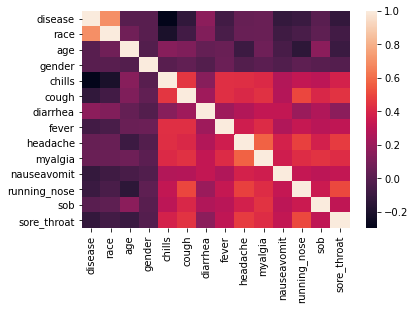

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.heatmap(corr_df)

These are the edges and their weights sorted descending.

In [6]:
import numpy as np
import itertools

edge_df = pd.Series(corr_df.values[np.triu_indices_from(corr_df.values, k=1)],
          index=itertools.combinations(df.columns, 2)) \
    .sort_values(ascending=False) \
    .to_frame(name='p') \
    .assign(abs_p=lambda d: np.abs(d['p'])) \
    .sort_values(['abs_p'], ascending=False)
edge_df.head()

,p,abs_p
"(disease, race)",0.698362,0.698362
"(headache, myalgia)",0.573924,0.573924
"(running_nose, sore_throat)",0.508476,0.508476
"(cough, running_nose)",0.501068,0.501068
"(headache, running_nose)",0.486561,0.486561


## Build graph

We will use the maximum weight spanning-tree algorithm (MWST).

In [7]:
import networkx as nx

u = nx.Graph()

for n in df.columns:
    u.add_node(n)
    
for (n1, n2), _ in edge_df.iterrows():
    if not nx.algorithms.shortest_paths.generic.has_path(u, n1, n2):
        u.add_edge(n1, n2)
    
    if len(u.edges()) == len(u.nodes()) - 1:
        break

In [8]:
len(u.nodes()), len(u.edges())

(14, 13)

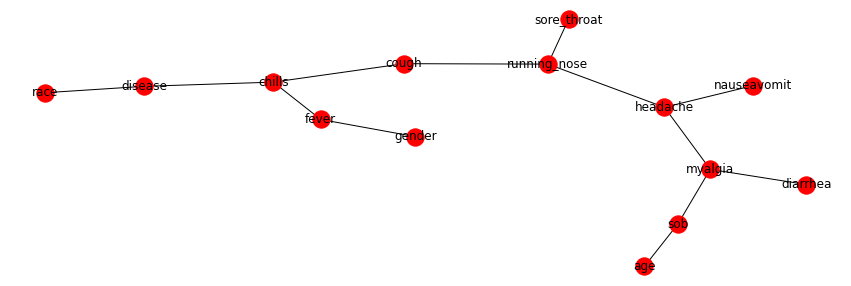

In [9]:
fig, ax = plt.subplots(figsize=(15, 5))

node_pos = nx.spring_layout(u)

nx.draw(**{
    'G': u,
    'ax': ax,
    'pos': node_pos,
    'with_labels': True,
    'node_color': 'r'
})

Great, we have a structure, but this graph is undirected, we need a directed acyclic graph (DAG). Remember our knowledge about serial, diverging and converging structures? Only the converging structure is statistically distinguishable from the serial and diverging structures.

- serial: A -> B -> C (implies A is conditionally independent of C given B)
- diverging: A <- B -> C (implies A is conditionally independent of C given B)
- converging: A -> B <- C (implies A is conditionally DEPENDENT of C given B)

And remember our knowledge on Poisson regression or log-linear modeling? How we can use Poisson regression to model at least 9 different models between any 3 variables. Let's make it simple, we find all triplets in the undirected graph, denoted as (A, B, C), where 

- A is connected to B, 
- C is connected to B, and
- A and C are NOT connected.

If D(A,C | B) (A and C are conditionally dependent given B), then we can orient the arcs as converging: A -> B <- C.

In [10]:
def get_triplets(n):
    def is_connected(a, c):
        n_a = set(u.neighbors(a))
        n_c = set(u.neighbors(c))
        
        if c not in n_a and a not in n_c:
            return False
        return True
        
    neighbors = list(u.neighbors(n))
    if len(neighbors) < 2:
        return []
    
    pairs = itertools.combinations(neighbors, 2)
    pairs = filter(lambda tup: not is_connected(*tup), pairs)
    pairs = map(lambda tup: (tup[0], n, tup[1]), pairs)
    return list(pairs)

triplets = list(itertools.chain(*[get_triplets(c) for c in df.columns]))
len(triplets)

16

In [11]:
triplets

[('race', 'disease', 'chills'),
 ('cough', 'chills', 'fever'),
 ('cough', 'chills', 'disease'),
 ('fever', 'chills', 'disease'),
 ('running_nose', 'cough', 'chills'),
 ('chills', 'fever', 'gender'),
 ('myalgia', 'headache', 'running_nose'),
 ('myalgia', 'headache', 'nauseavomit'),
 ('running_nose', 'headache', 'nauseavomit'),
 ('headache', 'myalgia', 'sob'),
 ('headache', 'myalgia', 'diarrhea'),
 ('sob', 'myalgia', 'diarrhea'),
 ('sore_throat', 'running_nose', 'cough'),
 ('sore_throat', 'running_nose', 'headache'),
 ('cough', 'running_nose', 'headache'),
 ('myalgia', 'sob', 'age')]

There are 16 triplets that we have to model (or test for conditional dependence) to attempt to turn the undirected edges to directed ones. Let's use the Chi-Square test of conditional independence. The critical value is 18.5 with 4 degrees of freedom (alpha=0.001). If any Chi-Square value is greater than 18.5, we fail to reject the null hypothesis (that A and C are conditionally independent given B).

In [12]:
def get_observed(a, b, c):
    def get_n(n, v, data):
        return data[data[n]==v]['observed'].sum()
        
    count = df[[a, b, c]] \
        .dropna() \
        .assign(observed=1) \
        .groupby([a, b, c]) \
        .sum() \
        .reset_index()
    
    N = count['observed'].sum()
    
    count = count.assign(
        a=lambda d: d.apply(lambda r: get_n(a, r[a], count), axis=1),
        b=lambda d: d.apply(lambda r: get_n(b, r[b], count), axis=1),
        c=lambda d: d.apply(lambda r: get_n(b, r[b], count), axis=1),
        expected=lambda d: d['a'] * d['b'] * d['c'] / (N*N),
        chi=lambda d: np.power(d['observed'] - d['expected'], 2) / d['expected'])
    
    dof = (2 * 2 * 2) - 2 - 2 - 2 + 2
    chi = count['chi'].sum()
    return {
        'a': a,
        'b': b,
        'c': c,
        'chi': chi, 
        'dof': dof,
        'sig': 1 if chi >= 19 else 0
    }

pd.DataFrame([get_observed(*t) for t in triplets]) \
    .sort_values(['chi'], ascending=False)

,a,b,c,chi,dof,sig
15,myalgia,sob,age,3.524911e+06,4,1
0,race,disease,chills,9.685151e+05,4,1
12,sore_throat,running_nose,cough,7.824393e+05,4,1
10,headache,myalgia,diarrhea,7.809949e+05,4,1
4,running_nose,cough,chills,7.309650e+05,4,1
7,myalgia,headache,nauseavomit,7.303296e+05,4,1
9,headache,myalgia,sob,6.974964e+05,4,1
11,sob,myalgia,diarrhea,6.476410e+05,4,1
13,sore_throat,running_nose,headache,6.224552e+05,4,1
1,cough,chills,fever,5.981784e+05,4,1


Ok, so it seems like all the triplets are significant! Wow. Since we have the triplets sorted from largest to smallest, use these triplets to orient the arcs A -> B <- C without creating cycle. If there are any arcs that remain undirected, use your best judgement to given them a direction without causing the graph to be cyclic.

In [13]:
edges = [
    ('age', 'sob'),
    ('myalgia', 'sob'),
    ('race', 'disease'),
    ('chills', 'disease'),
    ('cough', 'running_nose'),
    ('sore_throat', 'running_nose'),
    ('headache', 'myalgia'),
    ('diarrhea', 'myalgia'),
    ('headache', 'running_nose'),
    ('fever', 'chills'),
    ('cough', 'chills'),
    ('gender', 'fever'),
    ('headache', 'nauseavomit')
]

In [14]:
g = nx.DiGraph()

for n in df.columns:
    g.add_node(n)
    
for n1, n2 in edges:
    g.add_edge(n1, n2)

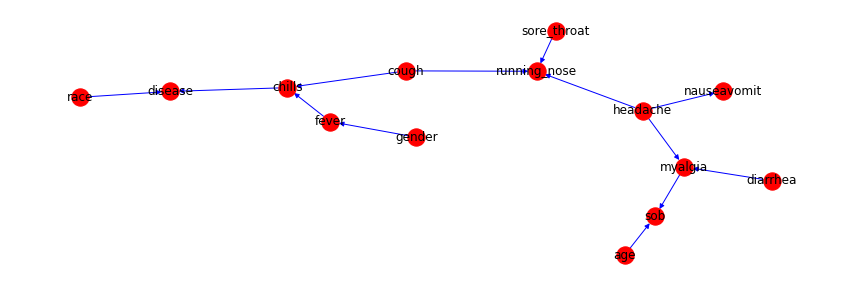

In [15]:
fig, ax = plt.subplots(figsize=(15, 5))

nx.draw(**{
    'G': g,
    'ax': ax,
    'pos': node_pos,
    'width': 1.0,
    'with_labels': True,
    'node_color': 'r',
    'edge_color': 'b'
})

Nice, now we have a DAG structure. We just need to learn the parameters. Remember how we did it with Logistic regression? Look at the other notebooks. 

After you learn the parameters, use py-bbn to create your Bayesian Belief Network (BBN). Make a prediction (e.g. how would having a running nose increase/decrease the chance of COVID?).

In [16]:
df['age'].value_counts()

20    247512
30    242364
50    232123
10    229470
40    220349
0     218438
60    209060
70    130044
80     70640
Name: age, dtype: int64

## Learn parameters

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

def get_values(parents):
    def get_pa_values(pa):
        pa_values = list(df[pa].value_counts().sort_index().index)
        return pa_values
        
    values = [get_pa_values(pa) for pa in parents]
    values = itertools.product(*values)
    return np.array(list(values))

def get_cpt(n):
    parents = sorted(list(g.predecessors(n)))
    
    if len(parents) == 0:
        s = df[n].value_counts()
        s = s / s.sum()
        s = s.sort_index()
        
        if n != 'age':
            return {
                'values': ['false', 'true'],
                'probs': [v for v in s.values],
                'parents': parents
            }
        else:
            return {
                'values': [f'{v:02}' for v in s.index],
                'probs': [v for v in s.values],
                'parents': parents
            }
    else:
        q = df[n].notna()
        X = df[q][parents]
        y = df[q][n]
        
        model = Pipeline([
            ('imputer', SimpleImputer()),
            ('classifier', LogisticRegression(solver='saga', random_state=37))
        ])
        
        model.fit(X, y)
        
        Z = np.array(get_values(parents))
        probs = np.ravel(model.predict_proba(Z))
        probs = [float(p) for p in probs]
        
        return {
            'values': ['false', 'true'],
            'probs': probs,
            'parents': parents,
            'Z': Z.shape
        }
  
cpts = {n: get_cpt(n) for n in df.columns}

In [18]:
cpts

{'disease': {'values': ['false', 'true'],
  'probs': [0.7113987962385642,
   0.2886012037614358,
   1.6913728330458788e-05,
   0.9999830862716695,
   0.9013070281293555,
   0.09869297187064456,
   6.266009161226549e-05,
   0.9999373399083877],
  'parents': ['chills', 'race'],
  'Z': (4, 2)},
 'race': {'values': ['false', 'true'],
  'probs': [0.8039522222222222, 0.19604777777777777],
  'parents': []},
 'age': {'values': ['00', '10', '20', '30', '40', '50', '60', '70', '80'],
  'probs': [0.12135444444444445,
   0.12748333333333334,
   0.13750666666666667,
   0.13464666666666666,
   0.12241611111111111,
   0.12895722222222222,
   0.11614444444444444,
   0.07224666666666667,
   0.03924444444444444],
  'parents': []},
 'gender': {'values': ['false', 'true'],
  'probs': [0.5070494444444444, 0.49295055555555556],
  'parents': []},
 'chills': {'values': ['false', 'true'],
  'probs': [0.8161176157341727,
   0.18388238426582731,
   0.5162619101006936,
   0.4837380898993064,
   0.4727066219971765

## Construct BBN

In [19]:
from pybbn.graph.dag import Bbn
from pybbn.graph.edge import Edge, EdgeType
from pybbn.graph.node import BbnNode
from pybbn.graph.variable import Variable
from pybbn.pptc.inferencecontroller import InferenceController
from pybbn.generator.bbngenerator import convert_for_drawing

bbn = Bbn()

bbn_nodes = {n: BbnNode(Variable(i, n, d['values']), d['probs']) for i, (n, d) in enumerate(cpts.items())}

for c in bbn_nodes:
    bbn.add_node(bbn_nodes[c])
    
for ch, d in cpts.items():
    ch_node = bbn_nodes[ch]
    
    for pa in d['parents']:
        pa_node = bbn_nodes[pa]
    
        bbn.add_edge(Edge(pa_node, ch_node, EdgeType.DIRECTED))
        print(f'{pa} --> {ch}')

chills --> disease
race --> disease
cough --> chills
fever --> chills
gender --> fever
diarrhea --> myalgia
headache --> myalgia
headache --> nauseavomit
cough --> running_nose
headache --> running_nose
sore_throat --> running_nose
age --> sob
myalgia --> sob


In [20]:
from pybbn.graph.jointree import EvidenceBuilder

join_tree = InferenceController.apply(bbn)

for node, posteriors in join_tree.get_posteriors().items():
    p = ', '.join([f'{val}={prob:.5f}' for val, prob in posteriors.items()])
    print(f'{node} : {p}')

fever : false=0.44222, true=0.55778
gender : false=0.50705, true=0.49295
headache : false=0.53858, true=0.46142
nauseavomit : false=0.77714, true=0.22286
race : false=0.80395, true=0.19605
chills : false=0.42832, true=0.57168
disease : false=0.32067, true=0.67933
cough : false=0.35308, true=0.64692
myalgia : false=0.55779, true=0.44221
diarrhea : false=0.82401, true=0.17599
running_nose : false=0.59489, true=0.40511
sore_throat : false=0.60578, true=0.39422
sob : false=0.69244, true=0.30756
age : 00=0.12135, 10=0.12748, 20=0.13751, 30=0.13465, 40=0.12242, 50=0.12896, 60=0.11614, 70=0.07225, 80=0.03924
